# AutoML and Timeseries Meetup - Hands On

https://github.com/NeuralAlgorithms/firefly-tutorials/tree/master/meetup_automl_timeseries


## Setup

In [73]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import RidgeCV, ARDRegression, ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.base import BaseEstimator, RegressorMixin
from tsfresh.feature_extraction.feature_calculators import mean, variance, number_peaks, approximate_entropy, median, \
    fft_coefficient, cwt_coefficients,  autocorrelation

## Example Time Series Data Set

Average time step: 0 days 01:00:00


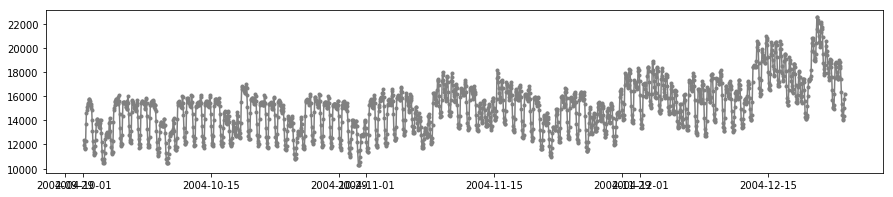

In [74]:
start_sample = 0
end_sample = 2000

df = pd.read_csv('data/AEP_hourly.csv', parse_dates=['Datetime'])

# sort dates ascending
df = df.set_index(['Datetime'])
df = df.sort_index()
df = df.reset_index()

t = df.Datetime[start_sample:end_sample]
y = df.AEP_MW[start_sample:end_sample]

plt.figure(figsize=(15,3))
plt.plot(t, y, '.-', c='gray')

t_diff_median = t.diff().median()
print('Average time step: {!s}'.format(t_diff_median))

## Hyperparameters  Wrappers

In [75]:
class HyperParameter():
    def __init__(self, name, min_value, max_value, discrete = False):
        self.name = name
        self.mn = min_value
        self.mx = max_value
        self.discrete = discrete
        self.random_state = np.random.RandomState()

    def random_value(self):
        if self.discrete:
            value = self.random_state.randint(self.mn, self.mx+1)
        else:
            value = self.random_state.rand()*(self.mx - self.mn) + self.mn

        return value


class ConfigSpace(object):
    def __init__(self, classes):
        self.classes = {cls.__name__ : cls for cls in classes}

    def get_random_configuration(self):
        out_config = {}
        for name, cls in self.classes.items():
            out_config[name] = {}
            for hp in cls.get_hyperparameters():
                out_config[name][hp.name] = hp.random_value()

        return out_config

    def run_configuration(self, x, config):
        additional_features = []
        for name in config:
            new_x = self.classes[name].run(x, **config[name])
            if new_x is not None:
                additional_features.append(new_x)

        if len(additional_features)>0:
            new_x = np.concatenate(additional_features, axis=1)
            x = np.concatenate((x, new_x), axis=1)
        return x

## Estimators Wrappers

In [76]:
class EstimatorBase():
    cls = None

    def __init__(self, **kwargs):
        self.estimator = self.cls(**kwargs)

    def fit(self, x, y):
        self.estimator.fit(x, y)

    def predict(self, x):
        return self.estimator.predict(x)

    @classmethod
    def get_hyperparameters(cls):
        raise NotImplementedError("abstract function")
    
    @classmethod
    def get_random_configuration(cls):
        out_config = {}

        for hp in cls.get_hyperparameters():
            out_config[hp.name] = hp.random_value()

        return out_config

    @classmethod
    def get_random_instance(cls):
        return cls(**cls.get_random_configuration())

class RandomForestWrapper(EstimatorBase):
    cls = RandomForestRegressor
    def __init__(self, **kwargs):
        if 'n_jobs' not in kwargs:
            kwargs['n_jobs'] = 3
        super(RandomForestWrapper, self).__init__(**kwargs)

    @classmethod
    def get_hyperparameters(cls):
        n_estimators = HyperParameter(name='n_estimators', min_value=10,
                                      max_value=100, discrete=True)
        max_depth = HyperParameter(name='max_depth', min_value=4,
                                   max_value=30, discrete=True)
        return [n_estimators, max_depth]


class ElasticNetWrapper(EstimatorBase):
    cls = ElasticNet

    def __init__(self, **kwargs):
        if 'tol' not in kwargs:
            kwargs['tol'] = np.power(10, kwargs['tol'])

        super(ElasticNetWrapper, self).__init__(**kwargs)

    @classmethod
    def get_hyperparameters(cls):
        alpha = HyperParameter(name='alpha', min_value=0, max_value=2, discrete=False)
        l1_ratio = HyperParameter(name='l1_ratio', min_value=0, max_value=1, discrete=False)
        tol = HyperParameter(name='tol', min_value=-4, max_value=-1,
                                  discrete=False)

        return [alpha, l1_ratio, tol]

## Timeseries features hyperparameters wrapper

In [77]:
class ConstantFeature():

    @classmethod
    def run(cls, x, n_lags=1, active=1):
        if active:
            return np.ones((x.shape[0], 1))*n_lags
        else:
            return None

    @classmethod
    def get_hyperparameters(cls):
        active = HyperParameter(name='active', min_value=0, max_value=1, discrete=True)
        n_lags = HyperParameter(name='n_lags', min_value=3, max_value=6, discrete=True)
        window_size = HyperParameter(name='window_size', min_value=12, max_value=72, discrete=True)
        return [n_lags, active, window_size]


## AutoML Experiemnts

In [78]:
def evaluate(X, y, preproc_config_space: ConfigSpace, preproc_config : dict, estimator: EstimatorBase, validation_size=100,
             test_size=100):

#     X = preproc_config_space.run_configuration(X, preproc_config)

    Xtrain = X[:-validation_size - test_size]
    Ytrain = y[:-validation_size - test_size]
    Xval = X[-validation_size - test_size:-test_size]
    Yval = y[-validation_size - test_size:-test_size]
    Xtest = X[-test_size:]
    Ytest = y[-test_size:]

    estimator.fit(Xtrain, Ytrain)

    test_predictions = estimator.predict(Xtest)
    val_predictions = estimator.predict(Xval)

    test_loss = mean_absolute_error(y_true=Ytest, y_pred=test_predictions)
    val_loss = mean_absolute_error(y_true=Yval, y_pred=val_predictions)
    return val_loss, test_loss

In [87]:
def run_experiments(n_experiments, estimator_wrapper: EstimatorBase, preproc_config_space: ConfigSpace):

    val_losses = []
    test_losses = []
    try_index = []
    best_val_loss = 1e100
    best_config = (None, None)
    
    for i in range(n_experiments):
    
        preproc_config = preproc_config_space.get_random_configuration()
        
        # prepare new dataset each experiment
        df_train = create_multivariate_data(window=preproc_config['ConstantFeature']['window_size'], 
                                            n_lags=preproc_config['ConstantFeature']['n_lags'])
        X = df_train.drop(['Datetime', 'AEP_MW', 'entropy'], axis=1)
        y = df_train.AEP_MW
        
        estimator_kwargs = estimator_wrapper.get_random_configuration()
        estimator = estimator_wrapper(**estimator_kwargs)
        
        print("Runing configurations: {}, {}". format(preproc_config, estimator_kwargs))

        val_loss, test_loss = evaluate(X, y,
                                       preproc_config_space=preproc_config_space,
                                       preproc_config=preproc_config,
                                       estimator=estimator,
                                       validation_size=300,
                                       test_size=300)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            val_losses.append(best_val_loss)
            test_losses.append(test_loss)
            try_index.append(i)
            best_config = (preproc_config, estimator_kwargs)
            print("experiment %d: Validation loss = %.3g, test loss = %.3g" % (i, val_loss, test_loss))

    print("Best validation loss = %.3g, test loss = %.3g" % (val_losses[-1], test_losses[-1]))
    print("Best config:\n%s\n%s" % best_config)

    plt.plot(try_index, val_losses, '.-b', try_index, test_losses, '.-r')
    plt.show()

## Experient preparations

In [88]:
def create_multivariate_data(window = 48, n_lags = 24):
    _mean = []
    _median = []
    _variance = []
    _entropy = []
    _peaks = []
    _autocorrelation = []
    dates = []
    values = []
    df_sub = df[start_sample:end_sample].copy()
    df_sub.index -= start_sample
    series_size = end_sample - start_sample
    for i in range(window+1, series_size):
        dates.append(df_sub.Datetime[i])
        values.append(df_sub.AEP_MW[i])
        _mean.append(mean(df_sub.AEP_MW[i-window:i]))
        _median.append(median(df_sub.AEP_MW[i-window:i]))
        _variance.append(variance(df_sub.AEP_MW[i-window:i]))
        _peaks.append(number_peaks(df_sub.AEP_MW[i-window:i], 3))
        _entropy.append(approximate_entropy(df_sub.AEP_MW[i-window:i], 10, 0.7))
        _autocorrelation.append(autocorrelation(df_sub.AEP_MW[i-window:i], 1))


    # lags
    lags = {}
#     n_lags = 20
    for i in range(1,n_lags):
        lags[i] = df_sub.AEP_MW.shift(i)


    df_lags = df_sub.copy()

    for i in range(1,n_lags):
        df_lags['lag' + str(i)] = 0

    for i in range(1,n_lags):
        df_lags['lag' + str(i)] = lags[i]

    # df_lags = df_lags.dropna()


    df_features = df_lags.copy()

    # additional statistical features
    df_features['mean'] = 0
    df_features['median'] = 0
    df_features['variance'] = 0
    df_features['entropy'] = 0

    df_features.AEP_MW = df_features.AEP_MW.astype(int)
    df_features['mean'][window+1:series_size] = np.asarray(_mean)
    df_features['median'][window+1:series_size] = np.asarray(_median)
    df_features['variance'][window+1:series_size] = np.asarray(_variance)
    df_features['entropy'][window+1:series_size] = np.asarray(_entropy)

    df_features = df_features.dropna()


    df_train = df_features[window + 1:series_size]
    return df_train


## Fitting Models

In [ ]:
run_experiments(n_experiments=100,
                    estimator_wrapper=ElasticNetWrapper,
                    preproc_config_space=ConfigSpace([ConstantFeature]))


Runing configurations: {'ConstantFeature': {'n_lags': 6, 'active': 0, 'window_size': 16}}, {'alpha': 0.30090417218985266, 'l1_ratio': 0.6207226445426764, 'tol': -2.46521435407808}
experiment 0: Validation loss = 250, test loss = 283
Runing configurations: {'ConstantFeature': {'n_lags': 3, 'active': 1, 'window_size': 26}}, {'alpha': 0.7115514484737608, 'l1_ratio': 0.3508231762480509, 'tol': -1.6709801320384718}
Runing configurations: {'ConstantFeature': {'n_lags': 5, 'active': 1, 'window_size': 32}}, {'alpha': 1.5215187951826297, 'l1_ratio': 0.3556018423987477, 'tol': -1.9373325940529367}
Runing configurations: {'ConstantFeature': {'n_lags': 4, 'active': 1, 'window_size': 58}}, {'alpha': 1.4084735330497904, 'l1_ratio': 0.7050251358106326, 'tol': -2.6139346293171126}
Runing configurations: {'ConstantFeature': {'n_lags': 6, 'active': 0, 'window_size': 29}}, {'alpha': 1.7499439204827942, 'l1_ratio': 0.4532698975058783, 'tol': -1.2269001420355021}
